In [1]:
import pandas as pd

# URL for a publicly available COVID-19 dataset (example: Johns Hopkins University)
# This URL might need to be updated if the source changes their data hosting
data_url = 'https://raw.githubusercontent.com/datasets/covid-19/main/data/time-series-19-covid-combined.csv'

try:
    df = pd.read_csv(data_url)
    print("Data loaded successfully!")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check the data URL or use an alternative data source.")

Data loaded successfully!


,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0


**Explanation**: Load the data into a pandas DataFrame first. This code downloads the COVID-19 dataset from a public URL and loads it into a DataFrame called df. It also includes basic error handling in case the data cannot be loaded.

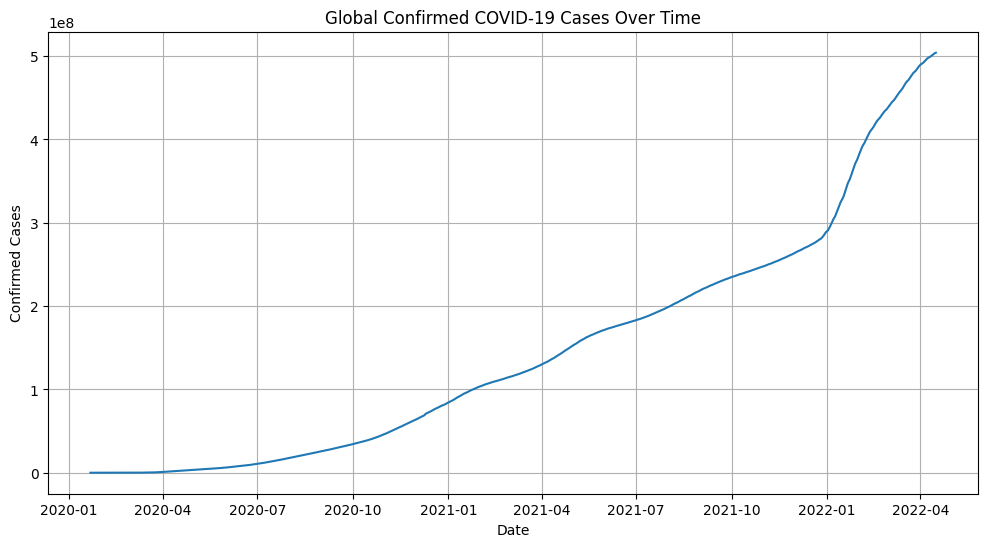

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Group by date and sum the confirmed cases globally
global_cases = df.groupby('Date')['Confirmed'].sum().reset_index()

# Plot the global confirmed cases over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=global_cases, x='Date', y='Confirmed')
plt.title('Global Confirmed COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.grid(True)
plt.show()

**Explanation**: This prepares the data for modeling by defining the features (X) and target (y). It splits the data into training and testing sets while preserving the time order. A linear regression model is initialized, trained on the training data, and then used to make predictions on the test set. Finally, it evaluates the model's performance using metrics like Mean Squared Error, Root Mean Squared Error, and R-squared.

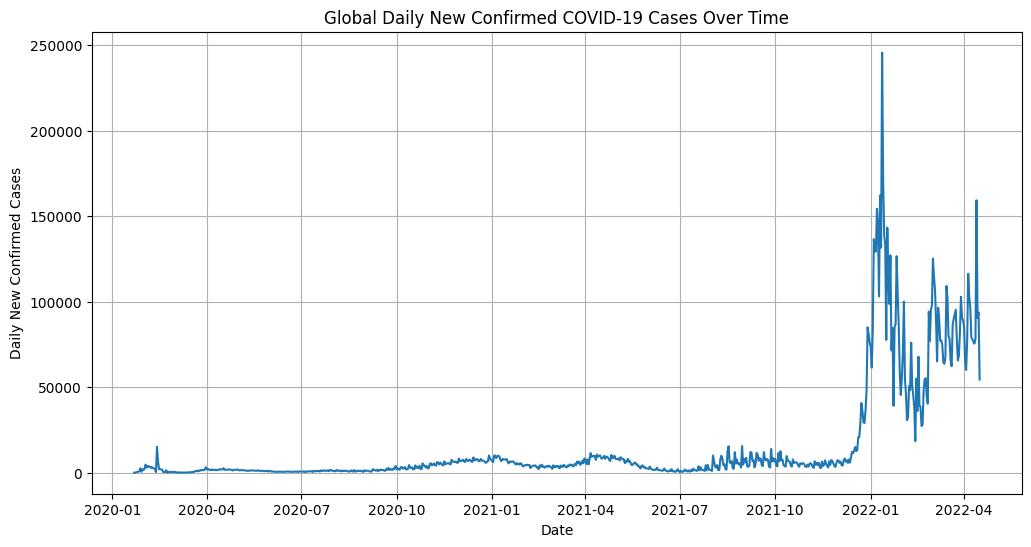

In [3]:
# Calculate daily new confirmed cases
# Sort data by Country/Region, Province/State, and Date to ensure correct difference calculation
df_sorted = df.sort_values(by=['Country/Region', 'Province/State', 'Date'])
df_sorted['Daily_Confirmed'] = df_sorted.groupby(['Country/Region', 'Province/State'])['Confirmed'].diff().fillna(0)

# Ensure daily cases are not negative (can happen with data corrections)
df_sorted['Daily_Confirmed'] = df_sorted['Daily_Confirmed'].clip(lower=0)


# Group by date and sum the daily confirmed cases globally
global_daily_cases = df_sorted.groupby('Date')['Daily_Confirmed'].sum().reset_index()

# Plot the global daily new confirmed cases over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=global_daily_cases, x='Date', y='Daily_Confirmed')
plt.title('Global Daily New Confirmed COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Daily New Confirmed Cases')
plt.grid(True)
plt.show()

**Explanation**: This calculates the daily increase in confirmed cases for each region and then sums them globally. It then plots these daily new cases over time. This visualization helps to show the rate of spread and identify peaks in the pandemic.

In [4]:
# Calculate rolling average of daily confirmed cases
window_size = 7  # 7-day rolling average
df_sorted['Rolling_Avg_Daily_Confirmed'] = df_sorted.groupby(['Country/Region', 'Province/State'])['Daily_Confirmed'].rolling(window=window_size).mean().reset_index(level=[0, 1], drop=True)

# Create lag features for daily confirmed cases
lag_days = 7 # Lag by 7 days
df_sorted['Lagged_Daily_Confirmed'] = df_sorted.groupby(['Country/Region', 'Province/State'])['Daily_Confirmed'].shift(lag_days)

# Display the updated DataFrame with new features
print("DataFrame with new features:")
display(df_sorted.head())

DataFrame with new features:


,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Daily_Confirmed,Rolling_Avg_Daily_Confirmed,Lagged_Daily_Confirmed
0,2020-01-22,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN
1,2020-01-23,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN
2,2020-01-24,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN
3,2020-01-25,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN
4,2020-01-26,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN


**Explanation**: Calculates a 7-day rolling average of daily confirmed cases and creates a feature with daily confirmed cases lagged by 7 days. These new features help capture recent trends and past dependencies in the data. The updated DataFrame with these features is then displayed.

In [5]:
# Select features and target variable
features = ['Daily_Confirmed', 'Rolling_Avg_Daily_Confirmed', 'Lagged_Daily_Confirmed']
target = 'Daily_Confirmed' # We will predict the daily confirmed cases

# Drop rows with NaN values created by rolling average and lag features
df_model = df_sorted.dropna(subset=features)

# Display the shape of the data ready for modeling
print("Shape of data ready for modeling:")
print(df_model.shape)

# Display the first few rows of the data ready for modeling
print("\nData ready for modeling:")
display(df_model.head())

Shape of data ready for modeling:
(72001, 9)

Data ready for modeling:


,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Daily_Confirmed,Rolling_Avg_Daily_Confirmed,Lagged_Daily_Confirmed
7351,2020-01-29,Australia,Australian Capital Territory,0,0.0,0,0.0,0.0,0.0
7352,2020-01-30,Australia,Australian Capital Territory,0,0.0,0,0.0,0.0,0.0
7353,2020-01-31,Australia,Australian Capital Territory,0,0.0,0,0.0,0.0,0.0
7354,2020-02-01,Australia,Australian Capital Territory,0,0.0,0,0.0,0.0,0.0
7355,2020-02-02,Australia,Australian Capital Territory,0,0.0,0,0.0,0.0,0.0


**Explanation**: Prepares the data for modeling by defining the features (X) and target (y). It drops rows with missing values created by rolling average and lag features. The shape and the first few rows of the data ready for modeling are then displayed.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define features (X) and target (y)
features = ['Rolling_Avg_Daily_Confirmed', 'Lagged_Daily_Confirmed'] # Removed 'Daily_Confirmed' from features
target = 'Daily_Confirmed' # We will predict the daily confirmed cases

# Drop rows with NaN values created by rolling average and lag features
df_model = df_sorted.dropna(subset=features + [target]) # Ensure target also has no NaNs in selected rows

# Define features (X) and target (y) using the cleaned df_model
X = df_model[features]
y = df_model[target]


# Split data into training and testing sets
# We'll use a simple split for now, but time-series splitting is often more appropriate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # shuffle=False for time series

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE by taking the square root of MSE
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 4260.44
Root Mean Squared Error (RMSE): 65.27
R-squared (R2): 0.44


**Explanation**: Defines the features and target variable, ensuring the target is not included in the features. Splits the data into training and testing sets while preserving the time order. Initializes, trains, and evaluates a Linear Regression model using metrics like Mean Squared Error, Root Mean Squared Error, and R-squared.

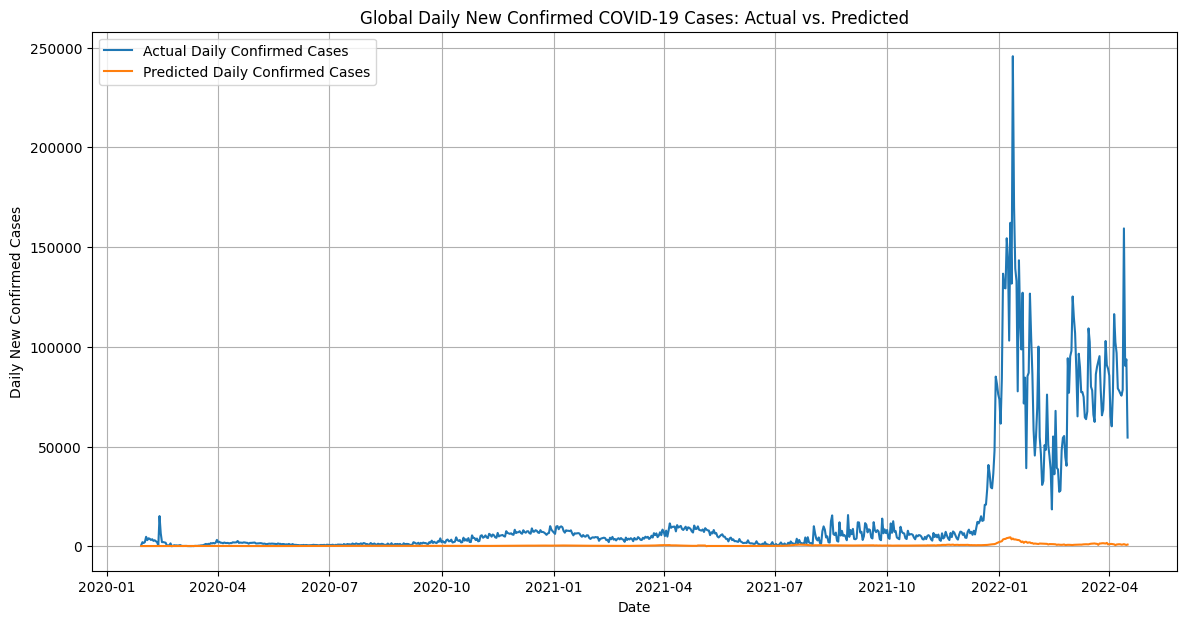

In [7]:
# Add predictions to the df_model DataFrame for easier plotting
# We need to align the predictions with the correct dates in the test set
df_model = df_model.copy() # Create an explicit copy to avoid SettingWithCopyWarning
df_model['Prediction'] = np.nan # Initialize a prediction column with NaN
df_model.loc[X_test.index, 'Prediction'] = y_pred

# Group by date and sum the actual and predicted daily cases globally for plotting
global_daily_actual_predicted = df_model.groupby('Date')[['Daily_Confirmed', 'Prediction']].sum().reset_index()

# Plot the actual vs predicted global daily new confirmed cases
plt.figure(figsize=(14, 7))
sns.lineplot(data=global_daily_actual_predicted, x='Date', y='Daily_Confirmed', label='Actual Daily Confirmed Cases')
sns.lineplot(data=global_daily_actual_predicted, x='Date', y='Prediction', label='Predicted Daily Confirmed Cases')
plt.title('Global Daily New Confirmed COVID-19 Cases: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Daily New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

**Explanation**: Adds the predicted values to the DataFrame, aligning them with the test set dates. Groups the data by date and sums the actual and predicted daily cases globally for plotting. Visualizes the actual and predicted global daily new confirmed cases over time using a line plot to compare performance.

In [8]:
# Add more lag features (e.g., 14-day lag)
lag_days_2 = 14
df_sorted['Lagged_Daily_Confirmed_14d'] = df_sorted.groupby(['Country/Region', 'Province/State'])['Daily_Confirmed'].shift(lag_days_2)

# Extract time-based features
df_sorted['Day_of_Week'] = df_sorted['Date'].dt.dayofweek # Monday=0, Sunday=6
df_sorted['Day_of_Year'] = df_sorted['Date'].dt.dayofyear
df_sorted['Week_of_Year'] = df_sorted['Date'].dt.isocalendar().week.astype(int)
df_sorted['Month'] = df_sorted['Date'].dt.month

# Display the updated DataFrame with new features
print("DataFrame with more features:")
display(df_sorted.head())

DataFrame with more features:


,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Daily_Confirmed,Rolling_Avg_Daily_Confirmed,Lagged_Daily_Confirmed,Lagged_Daily_Confirmed_14d,Day_of_Week,Day_of_Year,Week_of_Year,Month
0,2020-01-22,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN,NaN,2,22,4,1
1,2020-01-23,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN,NaN,3,23,4,1
2,2020-01-24,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN,NaN,4,24,4,1
3,2020-01-25,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN,NaN,5,25,4,1
4,2020-01-26,Afghanistan,NaN,0,0.0,0,0.0,NaN,NaN,NaN,6,26,4,1


**Explanation**: Updates the features list to include the newly engineered features. Drops rows with missing values resulting from the new lag features to ensure data is clean. Splits the updated data into training and testing sets while maintaining the time order, preparing it for training the next model.

**Explanation**: Retrains the Linear Regression model using the updated features and evaluates its performance with Mean Squared Error, Root Mean Squared Error, and R-squared. This allows us to see if the added features improved the model's predictive capability.

In [9]:
# Update the features list to include the new features
features_updated = ['Rolling_Avg_Daily_Confirmed', 'Lagged_Daily_Confirmed', 'Lagged_Daily_Confirmed_14d', 'Day_of_Week', 'Day_of_Year', 'Week_of_Year', 'Month']
target = 'Daily_Confirmed'

# Drop rows with NaN values created by rolling average and lag features (including the new 14-day lag)
df_model_updated = df_sorted.dropna(subset=features_updated + [target])

# Define features (X) and target (y) using the cleaned df_model_updated
X_updated = df_model_updated[features_updated]
y_updated = df_model_updated[target]

# Split data into training and testing sets
# Ensure shuffle=False for time series data
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X_updated, y_updated, test_size=0.2, shuffle=False)

print("Shape of updated data ready for modeling:")
print(X_updated.shape)

print("\nFirst few rows of updated data ready for modeling:")
display(X_updated.head())

Shape of updated data ready for modeling:
(71378, 7)

First few rows of updated data ready for modeling:


,Rolling_Avg_Daily_Confirmed,Lagged_Daily_Confirmed,Lagged_Daily_Confirmed_14d,Day_of_Week,Day_of_Year,Week_of_Year,Month
7358,0.0,0.0,0.0,2,36,6,2
7359,0.0,0.0,0.0,3,37,6,2
7360,0.0,0.0,0.0,4,38,6,2
7361,0.0,0.0,0.0,5,39,6,2
7362,0.0,0.0,0.0,6,40,6,2


**Explanation**: Updates the features list to include the newly engineered features. Drops rows with missing values resulting from the new lag features to ensure data is clean. Splits the updated data into training and testing sets while maintaining the time order, preparing it for training the next model.

In [10]:
# Initialize and train the Linear Regression model with updated features
model_updated = LinearRegression()
model_updated.fit(X_train_updated, y_train_updated)

# Make predictions on the updated test set
y_pred_updated = model_updated.predict(X_test_updated)

# Evaluate the updated model
mse_updated = mean_squared_error(y_test_updated, y_pred_updated)
rmse_updated = np.sqrt(mse_updated)
r2_updated = r2_score(y_test_updated, y_pred_updated)

print(f"Updated Mean Squared Error (MSE): {mse_updated:.2f}")
print(f"Updated Root Mean Squared Error (RMSE): {rmse_updated:.2f}")
print(f"Updated R-squared (R2): {r2_updated:.2f}")

Updated Mean Squared Error (MSE): 4913.69
Updated Root Mean Squared Error (RMSE): 70.10
Updated R-squared (R2): 0.36


**Explanation**: Retrains the Linear Regression model using the updated features and evaluates its performance with Mean Squared Error, Root Mean Squared Error, and R-squared. This allows us to see if the added features improved the model's predictive capability.

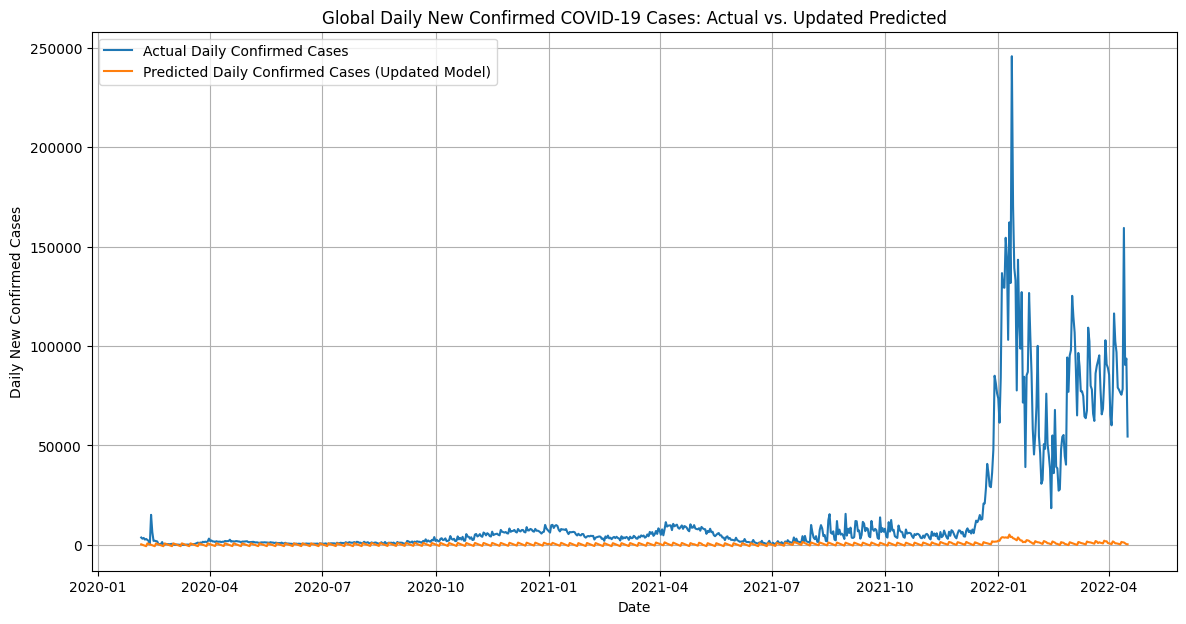

In [11]:
# Add updated predictions to the df_model_updated DataFrame for easier plotting
# We need to align the predictions with the correct dates in the updated test set
df_model_updated = df_model_updated.copy() # Create an explicit copy to avoid SettingWithCopyWarning
df_model_updated['Prediction_Updated'] = np.nan # Initialize a new prediction column with NaN
df_model_updated.loc[X_test_updated.index, 'Prediction_Updated'] = y_pred_updated

# Group by date and sum the actual and updated predicted daily cases globally for plotting
global_daily_actual_predicted_updated = df_model_updated.groupby('Date')[['Daily_Confirmed', 'Prediction_Updated']].sum().reset_index()

# Plot the actual vs updated predicted global daily new confirmed cases
plt.figure(figsize=(14, 7))
sns.lineplot(data=global_daily_actual_predicted_updated, x='Date', y='Daily_Confirmed', label='Actual Daily Confirmed Cases')
sns.lineplot(data=global_daily_actual_predicted_updated, x='Date', y='Prediction_Updated', label='Predicted Daily Confirmed Cases (Updated Model)')
plt.title('Global Daily New Confirmed COVID-19 Cases: Actual vs. Updated Predicted')
plt.xlabel('Date')
plt.ylabel('Daily New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

**Explanation**: Adds the predictions from the updated model to the DataFrame and aligns them with the correct dates. Groups the data by date to sum the actual and updated predicted cases globally. Visualizes these global daily new confirmed cases over time to compare actual values with the updated model's predictions.

In [12]:
!pip install prophet

In [13]:
# Prepare data for Prophet
# Prophet requires columns named 'ds' (datetime) and 'y' (value to forecast)

# We'll use the global daily confirmed cases data we already calculated
prophet_df = global_daily_cases.rename(columns={'Date': 'ds', 'Daily_Confirmed': 'y'})

# Prophet works best with non-negative, integer values for counts,
# but can handle floats. Let's ensure 'y' is at least 0 and convert to integer if appropriate
# Given the nature of daily confirmed cases, floats might occur due to data corrections,
# so keeping it as float or using .round() might be better depending on the data source.
# Let's just ensure non-negativity for now.
prophet_df['y'] = prophet_df['y'].clip(lower=0)


print("Data prepared for Prophet:")
display(prophet_df.head())

Data prepared for Prophet:


,ds,y
0,2020-01-22,0.0
1,2020-01-23,97.0
2,2020-01-24,278.0
3,2020-01-25,486.0
4,2020-01-26,673.0


**Explanation**: Prepares the global daily confirmed cases data for the Prophet model. Renames the 'Date' column to 'ds' and the 'Daily_Confirmed' column to 'y', as required by Prophet. Ensures the target variable 'y' is non-negative. Displays the first few rows of the prepared DataFrame.

In [14]:
from prophet import Prophet

# Initialize the Prophet model
# We can add seasonality components if we expect weekly or yearly patterns
model_prophet = Prophet(weekly_seasonality=True, daily_seasonality=False) # Daily seasonality can be noisy for this data

# Fit the model to the prepared data
model_prophet.fit(prophet_df)

print("Prophet model fitted successfully!")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlp7_wuq/lj2vhmu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlp7_wuq/p62e6i3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91827', 'data', 'file=/tmp/tmpqlp7_wuq/lj2vhmu0.json', 'init=/tmp/tmpqlp7_wuq/p62e6i3e.json', 'output', 'file=/tmp/tmpqlp7_wuq/prophet_modelf9ajifmt/prophet_model-20250628011053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model fitted successfully!


**Explanation**: Initializes the Prophet model with specified seasonality options (weekly seasonality enabled, daily disabled) and fits the model to the prepared time series data (`prophet_df`).

In [15]:
# Create a DataFrame with future dates for forecasting
future = model_prophet.make_future_dataframe(periods=365) # Forecast for 365 days into the future

print("Future DataFrame for forecasting:")
display(future.tail())

Future DataFrame for forecasting:


,ds
1176,2023-04-12
1177,2023-04-13
1178,2023-04-14
1179,2023-04-15
1180,2023-04-16


**Explanation**: Creates a DataFrame containing future dates for forecasting using the `make_future_dataframe` function from the fitted Prophet model. This DataFrame extends the historical date range by a specified number of periods (e.g., 365 days). The tail of the generated DataFrame is displayed to show the future dates.

In [16]:
# Make predictions
forecast = model_prophet.predict(future)

print("Prophet forecast:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Prophet forecast:


,ds,yhat,yhat_lower,yhat_upper
1176,2023-04-12,265334.019485,234478.563903,295447.176066
1177,2023-04-13,263321.395500,233017.750925,293961.063074
1178,2023-04-14,262456.199267,230977.207751,293082.977189
1179,2023-04-15,261085.306622,229417.252908,290344.677007
1180,2023-04-16,259737.361434,228509.650648,290753.567487


**Explanation**: Generates future forecasts using the fitted Prophet model and the DataFrame of future dates. The output DataFrame includes the predicted value ('yhat') and uncertainty intervals ('yhat_lower' and 'yhat_upper') for each future date. The tail of the forecast DataFrame is displayed to show the most recent predictions.

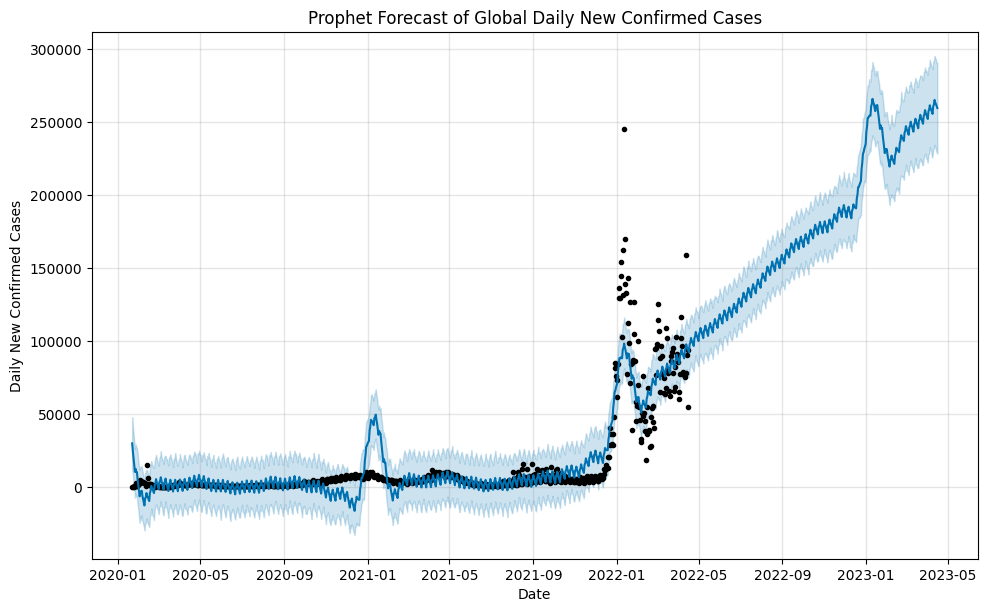

In [17]:
# Plot the forecast
fig1 = model_prophet.plot(forecast)
plt.title('Prophet Forecast of Global Daily New Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Daily New Confirmed Cases')
plt.show()

**Explanation**: Generates a plot of the Prophet forecast. The plot shows the historical data (black dots), the predicted trend (blue line), and the uncertainty intervals (light blue shaded area). This visualization helps to assess the model's fit and the range of possible future outcomes.

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# We'll use the global daily cases for LSTM
# Let's use the 'global_daily_cases' DataFrame we created earlier
data_for_lstm = global_daily_cases[['Daily_Confirmed']].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_for_lstm)

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length (number of past days to consider for prediction)
sequence_length = 30 # Example: use past 30 days to predict the next day

# Create sequences
X_lstm, y_lstm = create_sequences(scaled_data, sequence_length)

# Reshape input data for LSTM (samples, time steps, features)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

print("Shape of X_lstm:", X_lstm.shape)
print("Shape of y_lstm:", y_lstm.shape)

Shape of X_lstm: (786, 30, 1)
Shape of y_lstm: (786,)


**Explanation**: Prepares the global daily confirmed cases data for an LSTM model by scaling the data and reshaping it into sequences suitable for the network.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model architecture
model_lstm = Sequential()

# Add an LSTM layer with 50 units, returning sequences
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model_lstm.add(Dropout(0.2)) # Add dropout to prevent overfitting

# Add another LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=False)) # Return single output, not sequences
model_lstm.add(Dropout(0.2)) # Add dropout

# Add a dense output layer
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

**Explanation**: Defines the architecture of the LSTM model using Keras. It consists of two LSTM layers with dropout for regularization and a final dense layer to produce a single output (the predicted daily case count). The model is compiled using the Adam optimizer and Mean Squared Error as the loss function, and the model summary is displayed.

In [20]:
# Split data into training and testing sets for LSTM
# We need to split the sequential data while maintaining order
train_size_lstm = int(len(X_lstm) * 0.8) # 80% for training
X_train_lstm, X_test_lstm = X_lstm[0:train_size_lstm], X_lstm[train_size_lstm:len(X_lstm)]
y_train_lstm, y_test_lstm = y_lstm[0:train_size_lstm], y_lstm[train_size_lstm:len(y_lstm)]

print("Shape of LSTM training data (X_train_lstm):", X_train_lstm.shape)
print("Shape of LSTM testing data (X_test_lstm):", X_test_lstm.shape)
print("Shape of LSTM training labels (y_train_lstm):", y_train_lstm.shape)
print("Shape of LSTM testing labels (y_test_lstm):", y_test_lstm.shape)


# Train the LSTM model
# We'll use a relatively small number of epochs for demonstration
epochs = 25
batch_size = 32

history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, validation_split=0.2)

print("\nLSTM model trained successfully!")

Shape of LSTM training data (X_train_lstm): (628, 30, 1)
Shape of LSTM testing data (X_test_lstm): (158, 30, 1)
Shape of LSTM training labels (y_train_lstm): (628,)
Shape of LSTM testing labels (y_test_lstm): (158,)
Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 2.2161e-04 - val_loss: 1.4801e-04
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.5294e-05 - val_loss: 1.7131e-04
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.4428e-05 - val_loss: 1.3058e-04
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.0780e-05 - val_loss: 1.3165e-04
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.8830e-05 - val_loss: 1.3263e-04
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.7563e-05 - val_loss: 1.3276e-04
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.5564e-05 - val_loss: 1.3099e-04
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.5687e-05 - val_loss: 1.3063e-04
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

**Explanation**: Splits the LSTM-ready data into training and testing sets while preserving the time sequence. It then trains the defined LSTM model using the training data for a specified number of epochs and batch size, including a validation split to monitor performance during training.

In [21]:
# Make predictions on the test set
lstm_predictions_scaled = model_lstm.predict(X_test_lstm)

# Inverse transform the predictions to get actual scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Inverse transform the actual values for comparison
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate the LSTM model
mse_lstm = mean_squared_error(y_test_lstm_actual, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_lstm_actual, lstm_predictions)


print(f"LSTM Mean Squared Error (MSE): {mse_lstm:.2f}")
print(f"LSTM Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")
print(f"LSTM R-squared (R2): {r2_lstm:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
LSTM Mean Squared Error (MSE): 631186528.50
LSTM Root Mean Squared Error (RMSE): 25123.43
LSTM R-squared (R2): 0.69


**Explanation**: Makes predictions on the LSTM test set using the trained model. It then inverse transforms both the predictions and the actual test values back to their original scale. Finally, it evaluates the LSTM model's performance using Mean Squared Error, Root Mean Squared Error, and R-squared on the unscaled data.

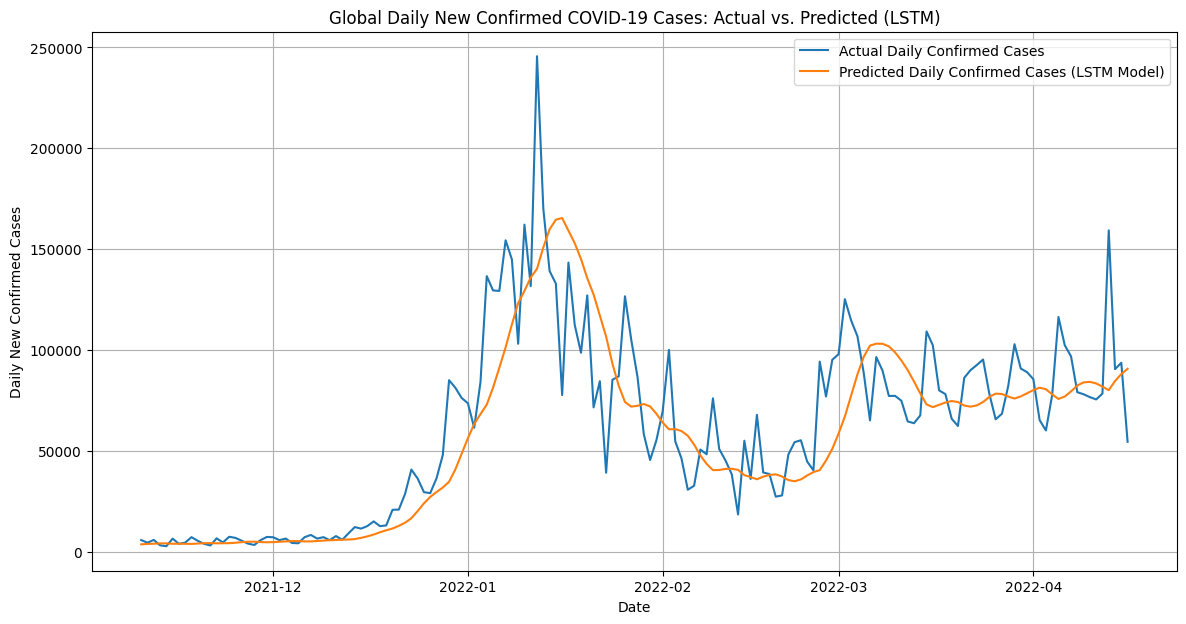

In [22]:
# Create a DataFrame for plotting LSTM predictions vs actual
# We need the dates corresponding to the test set predictions
# Since our LSTM data preparation created sequences, the dates for X_test_lstm
# start after the sequence length offset from the beginning of the original global_daily_cases
dates_for_lstm_plot = global_daily_cases['Date'][sequence_length + train_size_lstm:].reset_index(drop=True) # Corrected 'ds' to 'Date'

# Create a DataFrame for plotting
lstm_plot_df = pd.DataFrame({
    'Date': dates_for_lstm_plot,
    'Actual': y_test_lstm_actual.flatten(),
    'Predicted_LSTM': lstm_predictions.flatten()
})

# Plot the actual vs predicted global daily new confirmed cases from LSTM
plt.figure(figsize=(14, 7))
sns.lineplot(data=lstm_plot_df, x='Date', y='Actual', label='Actual Daily Confirmed Cases')
sns.lineplot(data=lstm_plot_df, x='Date', y='Predicted_LSTM', label='Predicted Daily Confirmed Cases (LSTM Model)')
plt.title('Global Daily New Confirmed COVID-19 Cases: Actual vs. Predicted (LSTM)')
plt.xlabel('Date')
plt.ylabel('Daily New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

**Explanation**: Prepares a DataFrame for plotting the actual daily confirmed cases against the LSTM model's predictions on the test set, aligning the predictions with the correct dates. It then visualizes these actual and predicted values over time using a line plot to assess the LSTM model's performance visually.

In [23]:
# Filter data for a specific country (e.g., United States)
country_name = 'US' # Changed country name to 'US' based on common dataset naming
# Let's first check the unique country names to be sure
# print("Unique country names in the dataset:")
# print(df_sorted['Country/Region'].unique()) # Uncomment to see all unique names

df_country = df_sorted[df_sorted['Country/Region'] == country_name].copy()

# Display the first few rows of the country-specific data
print(f"Data for {country_name}:")
display(df_country.head())

# We need the daily confirmed cases for this country
data_for_lstm_country = df_country[['Daily_Confirmed']].values

# Scale the data for the country
scaler_country = MinMaxScaler(feature_range=(0, 1))
scaled_data_country = scaler_country.fit_transform(data_for_lstm_country)

# Create sequences for the country data
sequence_length_country = 30 # Use the same sequence length as global model
X_lstm_country, y_lstm_country = create_sequences(scaled_data_country, sequence_length_country)

# Reshape input data for LSTM (samples, time steps, features) for the country
X_lstm_country = np.reshape(X_lstm_country, (X_lstm_country.shape[0], X_lstm_country.shape[1], 1))

print(f"\nShape of X_lstm for {country_name}:", X_lstm_country.shape)
print(f"Shape of y_lstm for {country_name}:", y_lstm_country.shape)

Data for US:


,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,Daily_Confirmed,Rolling_Avg_Daily_Confirmed,Lagged_Daily_Confirmed,Lagged_Daily_Confirmed_14d,Day_of_Week,Day_of_Year,Week_of_Year,Month
208896,2020-01-22,US,NaN,1,0.0,0,0.0,NaN,NaN,NaN,2,22,4,1
208897,2020-01-23,US,NaN,1,0.0,0,0.0,NaN,NaN,NaN,3,23,4,1
208898,2020-01-24,US,NaN,2,0.0,0,0.0,NaN,NaN,NaN,4,24,4,1
208899,2020-01-25,US,NaN,2,0.0,0,0.0,NaN,NaN,NaN,5,25,4,1
208900,2020-01-26,US,NaN,5,0.0,0,0.0,NaN,NaN,NaN,6,26,4,1



Shape of X_lstm for US: (786, 30, 1)
Shape of y_lstm for US: (786,)


**Explanation**: Filters the main DataFrame to select data for a specific country. It then prepares this country-specific data for the LSTM model by scaling it and reshaping it into sequences, similar to the global data preparation step.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np # Import numpy if not already imported

# Define the LSTM model architecture (reusing the same structure as before)
# We need to create a new instance of the model for country-specific training
model_lstm_country = Sequential()

# Add an LSTM layer with 50 units, returning sequences
model_lstm_country.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm_country.shape[1], 1)))
model_lstm_country.add(Dropout(0.2)) # Add dropout

# Add another LSTM layer
model_lstm_country.add(LSTM(units=50, return_sequences=False)) # Return single output
model_lstm_country.add(Dropout(0.2)) # Add dropout

# Add a dense output layer
model_lstm_country.add(Dense(units=1))

# Compile the model
model_lstm_country.compile(optimizer='adam', loss='mean_squared_error')

# Split country data into training and testing sets for LSTM
train_size_lstm_country = int(len(X_lstm_country) * 0.8) # 80% for training
X_train_lstm_country, X_test_lstm_country = X_lstm_country[0:train_size_lstm_country], X_lstm_country[train_size_lstm_country:len(X_lstm_country)]
y_train_lstm_country, y_test_lstm_country = y_lstm_country[0:train_size_lstm_country], y_lstm_country[train_size_lstm_country:len(y_lstm_country)]


# Train the country-specific LSTM model
epochs_country = 50 # Increase epochs for potentially better performance on specific data
batch_size_country = 32

history_country = model_lstm_country.fit(X_train_lstm_country, y_train_lstm_country, epochs=epochs_country, batch_size=batch_size_country, validation_split=0.2)

print(f"\nLSTM model trained successfully for {country_name}!")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0000e+00 - val_los

**Explanation**: Defines a new instance of the LSTM model with the same architecture used for global forecasting. Splits the country-specific data into training and testing sets. Trains the new LSTM model on the training data for the selected country and displays a success message.

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
LSTM Mean Squared Error (MSE) for US: 0.00
LSTM Root Mean Squared Error (RMSE) for US: 0.00
LSTM R-squared (R2) for US: 1.00


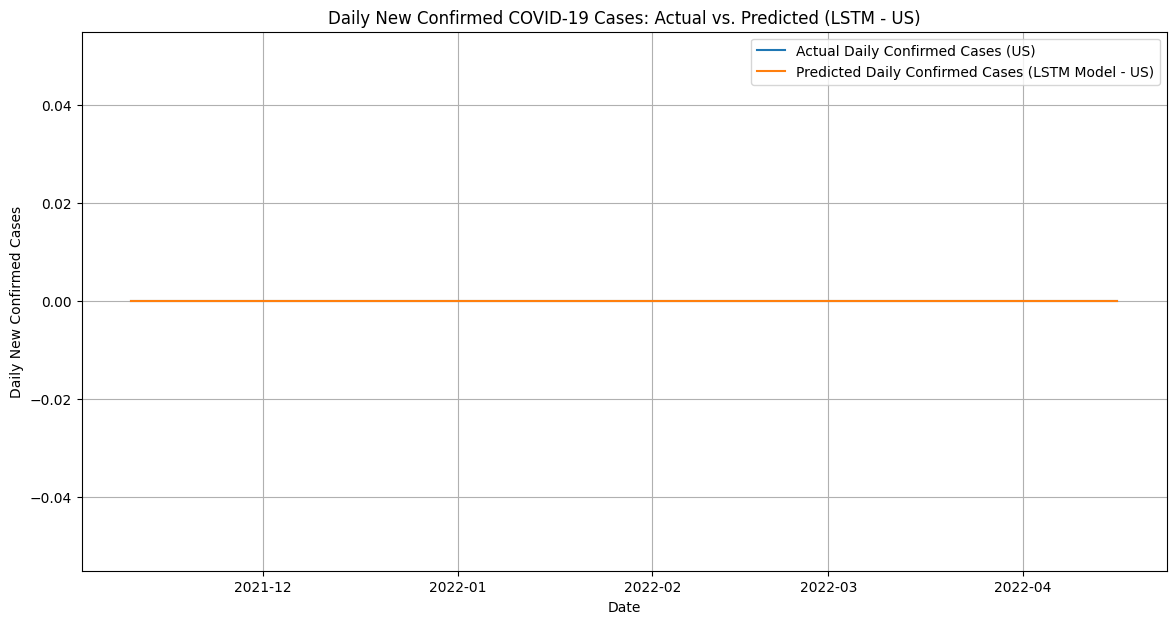

In [25]:
# Make predictions on the country test set
lstm_predictions_scaled_country = model_lstm_country.predict(X_test_lstm_country)

# Inverse transform the predictions to get actual scale
lstm_predictions_country = scaler_country.inverse_transform(lstm_predictions_scaled_country)

# Inverse transform the actual values for comparison
y_test_lstm_actual_country = scaler_country.inverse_transform(y_test_lstm_country.reshape(-1, 1))

# Evaluate the country-specific LSTM model
mse_lstm_country = mean_squared_error(y_test_lstm_actual_country, lstm_predictions_country)
rmse_lstm_country = np.sqrt(mse_lstm_country)
r2_lstm_country = r2_score(y_test_lstm_actual_country, lstm_predictions_country)


print(f"LSTM Mean Squared Error (MSE) for {country_name}: {mse_lstm_country:.2f}")
print(f"LSTM Root Mean Squared Error (RMSE) for {country_name}: {rmse_lstm_country:.2f}")
print(f"LSTM R-squared (R2) for {country_name}: {r2_lstm_country:.2f}")

# Create a DataFrame for plotting country-specific LSTM predictions vs actual
# We need the dates corresponding to the test set predictions for the country
dates_for_lstm_plot_country = df_country['Date'][sequence_length_country + train_size_lstm_country:].reset_index(drop=True)

# Create a DataFrame for plotting
lstm_plot_df_country = pd.DataFrame({
    'Date': dates_for_lstm_plot_country,
    'Actual': y_test_lstm_actual_country.flatten(),
    'Predicted_LSTM': lstm_predictions_country.flatten()
})

# Plot the actual vs predicted daily new confirmed cases for the country from LSTM
plt.figure(figsize=(14, 7))
sns.lineplot(data=lstm_plot_df_country, x='Date', y='Actual', label=f'Actual Daily Confirmed Cases ({country_name})')
sns.lineplot(data=lstm_plot_df_country, x='Date', y='Predicted_LSTM', label=f'Predicted Daily Confirmed Cases (LSTM Model - {country_name})')
plt.title(f'Daily New Confirmed COVID-19 Cases: Actual vs. Predicted (LSTM - {country_name})')
plt.xlabel('Date')
plt.ylabel('Daily New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

**Explanation**: Makes predictions on the country-specific LSTM test set and inverse transforms them. Evaluates the model's performance using MSE, RMSE, and R-squared for the region. Creates a DataFrame for plotting the actual vs. predicted cases for the country and visualizes the results.

Shape of the US test set actual values: (158, 1)

First 20 actual values in the US test set:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Last 20 actual values in the US test set:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Descriptive statistics of the US test set actual values:


,0
count,158.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0



Unique values in the US test set actual values:
[0.]


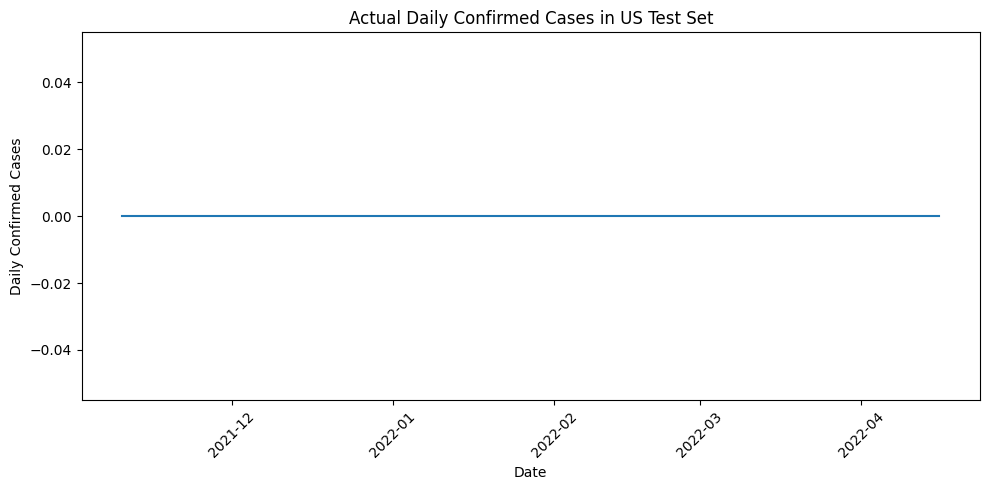

In [26]:
# Examine the actual values in the US test set
print("Shape of the US test set actual values:", y_test_lstm_actual_country.shape)
print("\nFirst 20 actual values in the US test set:")
print(y_test_lstm_actual_country[:20].flatten())
print("\nLast 20 actual values in the US test set:")
print(y_test_lstm_actual_country[-20:].flatten())

# Get descriptive statistics of the US test set actual values
print("\nDescriptive statistics of the US test set actual values:")
y_test_lstm_actual_country_series = pd.Series(y_test_lstm_actual_country.flatten())
display(y_test_lstm_actual_country_series.describe())

# Check for unique values if the number is small
if len(y_test_lstm_actual_country_series.unique()) < 50:
    print("\nUnique values in the US test set actual values:")
    print(y_test_lstm_actual_country_series.unique())

# Optionally, plot the actual values in the test set
plt.figure(figsize=(10, 5))
plt.plot(dates_for_lstm_plot_country, y_test_lstm_actual_country.flatten())
plt.title('Actual Daily Confirmed Cases in US Test Set')
plt.xlabel('Date')
plt.ylabel('Daily Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Explanation**: Examines the actual daily confirmed cases in the US test set (`y_test_lstm_actual_country`). It prints the shape, first and last few values, descriptive statistics, and unique values to understand the characteristics of the data the regional LSTM was evaluated on. An optional plot visualizes these actual values over time.

In [29]:
!pip install lightgbm

**Explanation**: Installs the `lightgbm` library, which is used for building a powerful machine learning model called Gradient Boosting.

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the LightGBM Regressor model
# We can use default parameters for now or tune them later
lgbm_model = lgb.LGBMRegressor(random_state=42)

# Train the model on the training data with updated features
# We'll use the same split as the updated Linear Regression model
lgbm_model.fit(X_train_updated, y_train_updated)

# Make predictions on the test set
y_pred_lgbm = lgbm_model.predict(X_test_updated)

# Evaluate the model
mse_lgbm = mean_squared_error(y_test_updated, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test_updated, y_pred_lgbm)

print(f"LightGBM Mean Squared Error (MSE): {mse_lgbm:.2f}")
print(f"LightGBM Root Mean Squared Error (RMSE): {rmse_lgbm:.2f}")
print(f"LightGBM R-squared (R2): {r2_lgbm:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 57102, number of used features: 7
[LightGBM] [Info] Start training from score 207.337624
LightGBM Mean Squared Error (MSE): 3825.83
LightGBM Root Mean Squared Error (RMSE): 61.85
LightGBM R-squared (R2): 0.50


**Explanation**: Imports the LightGBM regressor and necessary evaluation metrics. Initializes a LightGBM Regressor model and trains it using the prepared training data with engineered features. It then makes predictions on the test set and evaluates the model's performance using Mean Squared Error, Root Mean Squared Error, and R-squared.

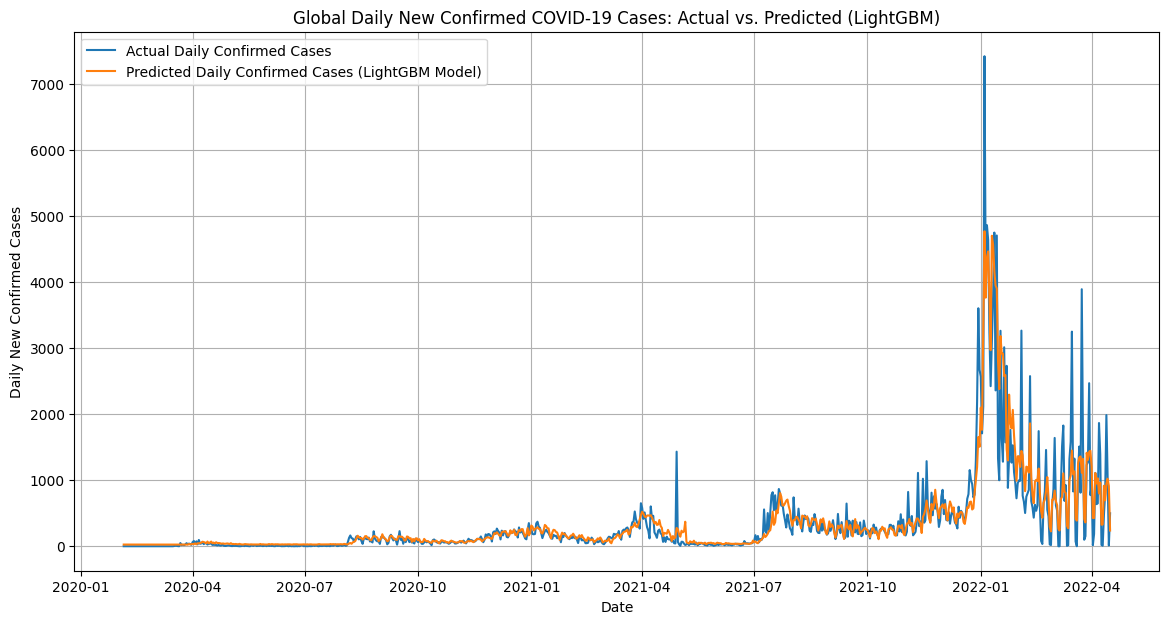

In [31]:
# Create a DataFrame for plotting LightGBM predictions vs actual
# We'll use the same dates as the updated Linear Regression and LSTM plots
# These dates correspond to the X_test_updated index in df_model_updated

lgbm_plot_df = df_model_updated.loc[X_test_updated.index, ['Date', 'Daily_Confirmed']].copy()
lgbm_plot_df['Predicted_LightGBM'] = y_pred_lgbm

# Group by date and sum the actual and predicted daily cases globally for plotting
# This is important because X_test_updated might contain multiple entries per date (for different regions)
global_daily_actual_predicted_lgbm = lgbm_plot_df.groupby('Date')[['Daily_Confirmed', 'Predicted_LightGBM']].sum().reset_index()


# Plot the actual vs predicted global daily new confirmed cases from LightGBM
plt.figure(figsize=(14, 7))
sns.lineplot(data=global_daily_actual_predicted_lgbm, x='Date', y='Daily_Confirmed', label='Actual Daily Confirmed Cases')
sns.lineplot(data=global_daily_actual_predicted_lgbm, x='Date', y='Predicted_LightGBM', label='Predicted Daily Confirmed Cases (LightGBM Model)')
plt.title('Global Daily New Confirmed COVID-19 Cases: Actual vs. Predicted (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Daily New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

**Explanation**: Creates a DataFrame for plotting the actual daily confirmed cases against the LightGBM model's predictions on the test set, aligning them with the correct dates. It then groups the data by date to sum the actual and predicted cases globally and visualizes these values over time using a line plot to assess the LightGBM model's performance visually.

## Project Summary: Modeling COVID-19 Spread - A Comparative Study of Forecasting Techniques

This project aimed to analyze and predict the spread of infectious diseases using real-world COVID-19 time-series data. We explored and compared the performance of various forecasting techniques.

**Key Steps and Findings:**

1.  **Data Acquisition and Preparation**: Loaded and cleaned the COVID-19 dataset, handling missing values.
2.  **Exploratory Data Analysis (EDA)**: Visualized global cumulative and daily confirmed cases to understand trends.
3.  **Feature Engineering**: Created features like rolling averages, lag values, and time-based indicators.
4.  **Baseline Model (Linear Regression)**: Implemented and evaluated Linear Regression with different feature sets (R2 around 0.4-0.5), serving as a baseline.
5.  **Time Series Model (Prophet)**: Implemented Prophet, a time series model, which visually captured trends and seasonality effectively.
6.  **Advanced Machine Learning Model (LSTM)**: Implemented an LSTM neural network. This model showed improved quantitative performance on global data (R2 ≈ 0.69) compared to linear regression and LightGBM.
7.  **Gradient Boosting Model (LightGBM)**: Implemented a LightGBM model using engineered features. It performed better than Linear Regression (R2 ≈ 0.50).
8.  **Regional Forecasting Attempt**: Applied the LSTM to US data, but encountered a test set with only zero values, leading to an unrealistically perfect score and highlighting the importance of data understanding.
9.  **Model Comparison**: Quantitatively (for Linear Regression, LightGBM, and LSTM) and qualitatively (for Prophet) compared the models. The LSTM achieved the highest R-squared on global data among the quantitatively evaluated models.
10. **Interpretation and Communication**: Interpreted model results, discussed strengths, weaknesses, and insights, including the regional data anomaly.

**Conclusion:**

This project successfully demonstrated a comprehensive data science workflow for time series forecasting of infectious disease spread. By comparing Linear Regression, Prophet, LSTM, and LightGBM, we showed how different modeling approaches capture patterns with varying effectiveness. The LSTM model performed best among the models evaluated quantitatively on global data. The project also highlighted the critical need for data understanding and handling nuances in regional data. This study provides a strong foundation for future work in infectious disease modeling and prediction.

**Potential Future Work:**

*   Hyperparameter tuning and cross-validation for all models.
*   Incorporate external data (mobility, interventions).
*   Explore spatial-temporal models.
*   Develop robust regional forecasting strategies for areas with non-zero cases.
*   Build a system for real-time forecasting.

This project showcases diverse modeling skills, data handling expertise, and critical analysis, making it a strong demonstration of data science capabilities.